## Feature Extraction and Data set Loading 

In [1]:
import glob
import os
import librosa as lr
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from scipy.io import wavfile
from scipy import signal

#### Emotions observed in both datasets

In [2]:
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fear',
  '07':'disgust',
  '08':'surprised'
}

tess_emotions=['angry','disgust','fear','ps','happy','sad']

ravdess_emotions=['neutral','calm','angry', 'happy','disgust','sad','fear','surprised']

observed_emotions = ['sad','angry','happy','disgust','surprised','neutral','calm','fear']

#### Extraction feature of the different features in the audio files

In [3]:
def extract_feature(file_name, mfcc, chroma, mel):
    X, sample_rate = lr.load(os.path.join(file_name), res_type='kaiser_fast')
    if chroma:
        stft=np.abs(lr.stft(X))
    result=np.array([])
    if mfcc:
        mfccs=np.mean(lr.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
    result=np.hstack((result, mfccs))
    if chroma:
        chroma=np.mean(lr.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    result=np.hstack((result, chroma))
    if mel:
        mel=np.mean(lr.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    result=np.hstack((result, mel))
    return result

#### Dataset Loading

In [4]:
def dataset_options():
    ravdess = True
    tess = True
    ravdess_speech = False
    ravdess_song = False
    data = {'ravdess':ravdess, 'ravdess_speech':ravdess_speech, 'ravdess_song':ravdess_song, 'tess':tess}
    return data

In [5]:
os.listdir(path='../SpeechEmotionRecognition')
def getListOfFiles(dirName):
    listOfFile=os.listdir(dirName)
    allFiles=list()
    for entry in listOfFile:
        fullPath=os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles=allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
    return allFiles

dirName1 = '../SpeechEmotionRecognition/Ravtess/RAVDESSDataset'
dirName2 = '../SpeechEmotionRecognition/Ravtess/TESSDataset'
listOfFiles1 = getListOfFiles(dirName1)
listOfFiles2 = getListOfFiles(dirName2)
listOfFiles = listOfFiles1 + listOfFiles2
len(listOfFiles)

4240

#### Visualising the Data

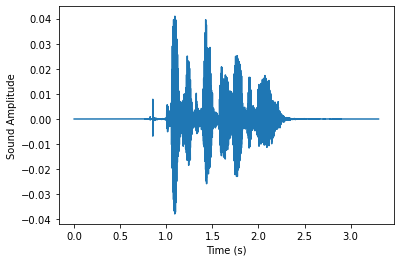

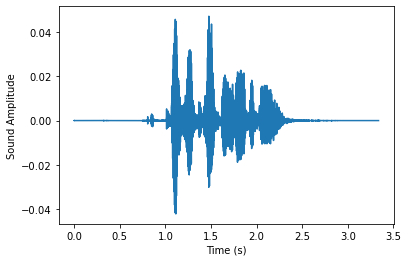

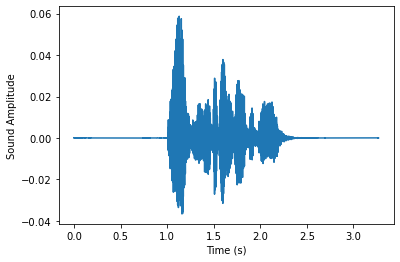

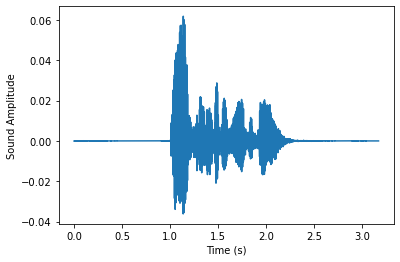

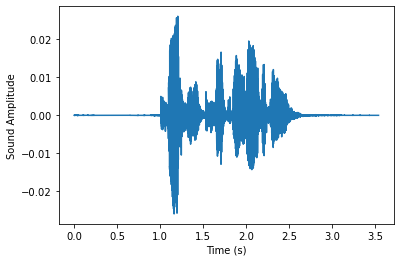

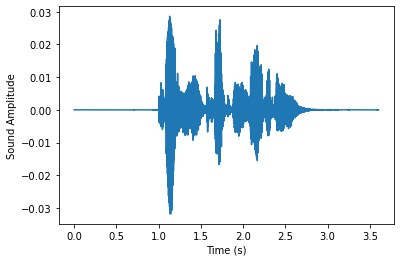

KeyboardInterrupt: 

In [6]:
for file in range(0 , len(listOfFiles) , 1):
    audio , sfreq = lr.load(listOfFiles[file])
    time = np.arange(0 , len(audio)) / sfreq
    
    fig ,ax = plt.subplots()
    ax.plot(time , audio)
    ax.set(xlabel = 'Time (s)' , ylabel = 'Sound Amplitude')
    plt.show()
    
#PLOT THE SEPCTOGRAM
for file in range(0 , len(listOfFiles) , 1):
     sample_rate , samples = wavfile.read(listOfFiles[file])
     frequencies , times, spectrogram = signal.spectrogram(samples, sample_rate) 
     plt.pcolormesh(times, frequencies, spectrogram)
     plt.imshow(spectrogram)*
     plt.ylabel('Frequency [Hz]')
     plt.xlabel('Time [sec]')
     plt.show()

In [7]:
def plot_signals(signals):
    fig , axes = plt.subplots(nrows=2, ncols=5,sharex =False , sharey=True, figsize=(20,5))
    fig.suptitle('Time Series' , size=16)
    i=0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1

def plot_fft(fft):
    fig , axes = plt.subplots(nrows=2, ncols=5,sharex =False , sharey=True, figsize=(20,5))
    fig.suptitle('Fourier Transform' , size=16)
    i=0
    for x in range(2):
        for y in range(5):
            data = list(fft.values())[i]
            Y,freq = data[0] , data[1]
            axes[x,y].set_title(list(fft.keys())[i])
            axes[x,y].plot(freq , Y)
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1
    
def plot_fbank(fbank):
    fig , axes = plt.subplots(nrows=2, ncols=5,sharex =False , sharey=True, figsize=(20,5))
    fig.suptitle('Filter Bank Coefficients' , size=16)
    i=0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(fbank.keys())[i])
            axes[x,y].imshow(list(fbank.values())[i],cmap='hot', interpolation = 'nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1
            
def plot_mfccs(mfccs):
    fig , axes = plt.subplots(nrows=2, ncols=5,sharex =False , sharey=True, figsize=(20,5))
    fig.suptitle('Mel Frequency Capstrum  Coefficients' , size=16)
    i=0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i],
                             cmap='hot', interpolation = 'nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1

def calc_fft(y,rate):
    n = len(y)
    freq = np.fft.rfftfreq(n , d= 1/rate)
    Y= abs(np.fft.rfft(y)/n)
    return(Y,freq)

In [8]:
def envelope(y , rate, threshold):
    mask=[]
    y=pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10) ,  min_periods=1 , center = True).mean()
    for mean in y_mean:
        if mean>threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

C:\Users\ameya\AppData\Local\Temp/ipykernel_4972/1128977120.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, data = wav.read(listOfFiles[file])


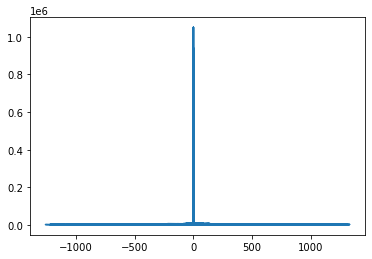

C:\Users\ameya\AppData\Local\Temp/ipykernel_4972/1128977120.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, data = wav.read(listOfFiles[file])


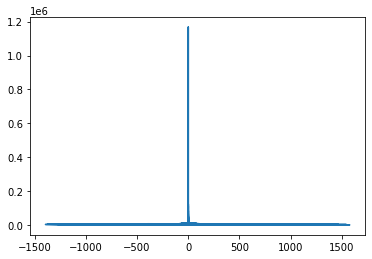

C:\Users\ameya\AppData\Local\Temp/ipykernel_4972/1128977120.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, data = wav.read(listOfFiles[file])


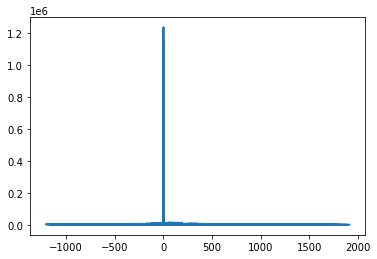

C:\Users\ameya\AppData\Local\Temp/ipykernel_4972/1128977120.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, data = wav.read(listOfFiles[file])


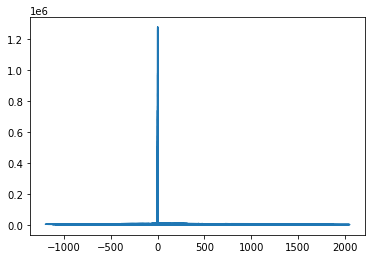

C:\Users\ameya\AppData\Local\Temp/ipykernel_4972/1128977120.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, data = wav.read(listOfFiles[file])


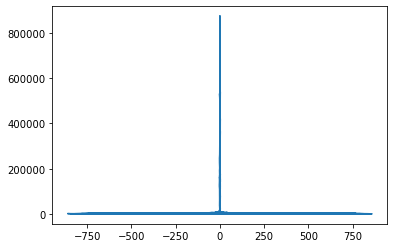

C:\Users\ameya\AppData\Local\Temp/ipykernel_4972/1128977120.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, data = wav.read(listOfFiles[file])


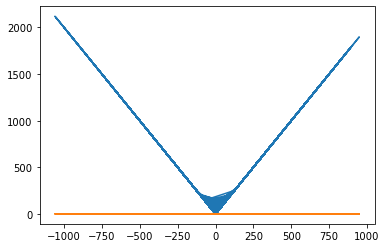

C:\Users\ameya\AppData\Local\Temp/ipykernel_4972/1128977120.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, data = wav.read(listOfFiles[file])


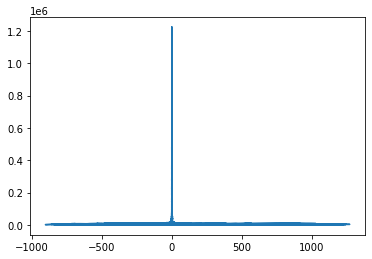

C:\Users\ameya\AppData\Local\Temp/ipykernel_4972/1128977120.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, data = wav.read(listOfFiles[file])


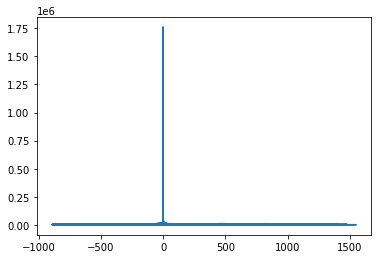

C:\Users\ameya\AppData\Local\Temp/ipykernel_4972/1128977120.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, data = wav.read(listOfFiles[file])


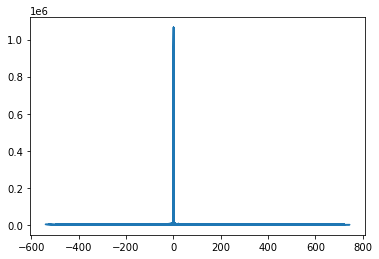

C:\Users\ameya\AppData\Local\Temp/ipykernel_4972/1128977120.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, data = wav.read(listOfFiles[file])


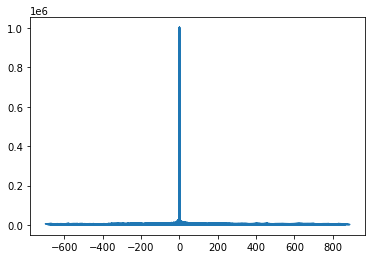

C:\Users\ameya\AppData\Local\Temp/ipykernel_4972/1128977120.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, data = wav.read(listOfFiles[file])


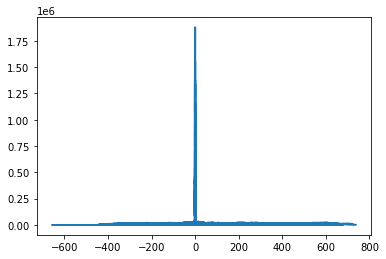

C:\Users\ameya\AppData\Local\Temp/ipykernel_4972/1128977120.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, data = wav.read(listOfFiles[file])


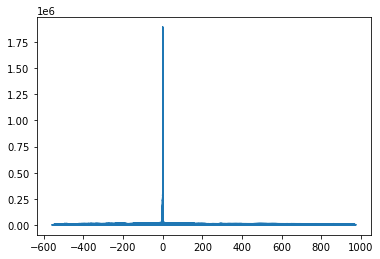

C:\Users\ameya\AppData\Local\Temp/ipykernel_4972/1128977120.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, data = wav.read(listOfFiles[file])


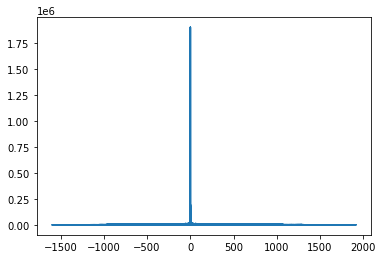

C:\Users\ameya\AppData\Local\Temp/ipykernel_4972/1128977120.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, data = wav.read(listOfFiles[file])


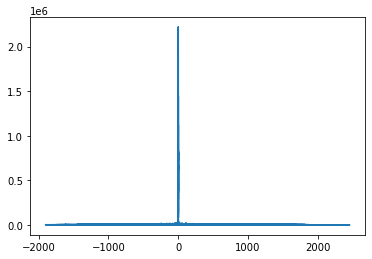

C:\Users\ameya\AppData\Local\Temp/ipykernel_4972/1128977120.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, data = wav.read(listOfFiles[file])


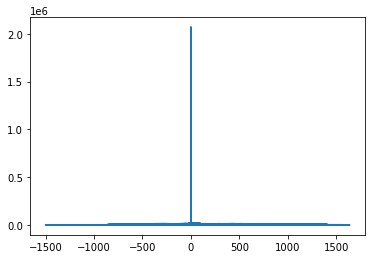

C:\Users\ameya\AppData\Local\Temp/ipykernel_4972/1128977120.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, data = wav.read(listOfFiles[file])


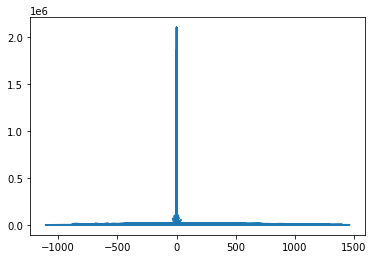

C:\Users\ameya\AppData\Local\Temp/ipykernel_4972/1128977120.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, data = wav.read(listOfFiles[file])


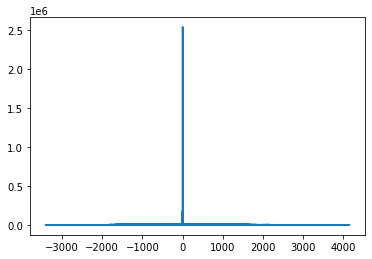

C:\Users\ameya\AppData\Local\Temp/ipykernel_4972/1128977120.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, data = wav.read(listOfFiles[file])


KeyboardInterrupt: 

In [9]:
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
from scipy.fftpack import fft
import numpy as np
for file in range(0 , len(listOfFiles) , 1):
    rate, data = wav.read(listOfFiles[file])
    fft_out = fft(data)
    %matplotlib inline
    plt.plot(data, np.abs(fft_out))
    plt.show()
    
signals={}
fft={}
fbank={}
mfccs={}
# load data
for file in range(0 , len(listOfFiles) , 1):
#     rate, data = wavfile.read(listOfFiles[file])
     signal,rate =librosa.load(listOfFiles[file] , sr=44100)
     mask = envelope(signal , rate , 0.0005)
     signals[file] = signal
     fft[file] = calc_fft(signal , rate)
    
     bank = logfbank(signal[:rate] , rate , nfilt = 26, nfft = 1103).T
     fbank[file] = bank
     mel = mfcc(signal[:rate] , rate , numcep =13 , nfilt = 26 , nfft=1103).T
     mfccs[file]=mel

plot_signals(signals)
plt.show()

plot_fft(fft)
plt.show()

plot_fbank(fbank)
plt.show()

plot_mfccs(mfccs)
plt.show()

In [29]:
import glob,pickle
for file in tqdm(glob.glob(r'../SpeechEmotionRecognition/Ravtess')):
    file_name = os.path.basename(file)
    signal , rate = librosa.load(file, sr=16000)
    mask = envelope(signal,rate, 0.0005)
    wavfile.write(filename= r'../SpeechEmotionRecognition/CleanedAudio'+str(file_name), rate=rate,data=signal[mask])

PermissionError: [Errno 13] Permission denied: '../SpeechEmotionRecognition/Ravtess'

In [15]:
from glob import glob
import os
import glob
def load_data(test_size=0.33):
    x,y=[],[]
    answer = 0
    for file in glob.glob('../SpeechEmotionRecognition/Ravtess/RAVDESSDataset/Actor_*/*.wav'):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            answer += 1
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append([emotion,file_name])
    for file in glob.glob('../SpeechEmotionRecognition/Ravtess/TESSDataset/*AF_*/*.wav'):
        file_name=os.path.basename(file)
        emotion=file_name.split("_")[2][:-4] 
        if emotion == 'ps':
            emotion = 'surprised'
        if emotion not in observed_emotions:
            answer += 1
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append([emotion,file_name])
    return train_test_split(np.array(x), y, test_size=test_size, random_state=42)

In [20]:
x_train, x_test, y_train, y_test = load_data(test_size=0.33)
print("--- Data loaded. ---")

C:\Users\ameya\AppData\Local\Temp/ipykernel_4972/3222446679.py:13: FutureWarning: Pass y=[-6.0831886e-09  1.6542382e-08 -3.1169741e-08 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel=np.mean(lr.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
C:\Users\ameya\AppData\Local\Temp/ipykernel_4972/3222446679.py:13: FutureWarning: Pass y=[-2.1265739e-06 -1.3072960e-05  3.3695295e-07 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel=np.mean(lr.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
C:\Users\ameya\AppData\Local\Temp/ipykernel_4972/3222446679.py:13: FutureWarning: Pass y=[ 1.9314628e-05  1.9197427e-05  3.3903023e-05 ...  4.0460545e-06
 -1.1559049e-05  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel=np.mean

--- Data loaded. ---


C:\Users\ameya\AppData\Local\Temp/ipykernel_4972/3222446679.py:13: FutureWarning: Pass y=[ 3.8397768e-05  6.1955216e-04  9.6964702e-04 ... -3.1133232e-04
 -1.1807788e-04  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel=np.mean(lr.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
C:\Users\ameya\AppData\Local\Temp/ipykernel_4972/3222446679.py:13: FutureWarning: Pass y=[ 1.4129491e-04  4.2569361e-04  4.8716879e-04 ... -2.3639778e-04
  5.6394932e-05  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel=np.mean(lr.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
C:\Users\ameya\AppData\Local\Temp/ipykernel_4972/3222446679.py:13: FutureWarning: Pass y=[-8.7881635e-05  2.8810071e-04  2.0234125e-04 ... -5.2179897e-04
 -9.3192226e-05  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel=np.mean

In [28]:
Trial_dict= {}
x = pd.DataFrame(Trial_dict["x"])
y = pd.DataFrame(Trial_dict["y"])

KeyError: 'x'

In [47]:
x.shape, y.shape

AttributeError: 'list' object has no attribute 'shape'

In [72]:
y=y.rename(columns= {0: 'emotion'})

In [73]:
data = pd.concat([x, y], axis =1)

In [75]:
data.tail()

,0,1,2,3,4,5,6,7,8,9,...,172,173,174,175,176,177,178,179,emotion,1
4235,-395.929657,67.676323,28.635458,48.602295,-8.099685,14.440633,-6.938863,-6.013683,-4.472199,0.174099,...,0.005282,0.005733,0.004973,0.001434,0.000183,0.000060,0.000006,2.359879e-07,sad,YAF_witch_sad.wav
4236,-408.480896,82.119164,20.141613,45.292274,-5.182439,4.444522,-11.409233,-9.444230,-2.910877,-7.445793,...,0.018789,0.012565,0.007197,0.003485,0.000439,0.000044,0.000003,1.061878e-07,sad,YAF_yearn_sad.wav
4237,-375.263794,72.433640,31.662107,47.805725,-10.990336,10.629903,-6.731672,-3.679457,-3.270216,-2.490313,...,0.005453,0.004470,0.002000,0.001324,0.000376,0.000059,0.000003,7.781927e-08,sad,YAF_yes_sad.wav
4238,-426.727997,74.208549,24.606394,42.251965,-8.101797,18.410795,-7.908656,-7.860358,-4.703382,-0.679921,...,0.003976,0.003034,0.001676,0.000527,0.000149,0.000034,0.000003,5.376711e-08,sad,YAF_young_sad.wav
4239,-414.413483,60.110760,26.068558,46.311909,-3.315051,12.827894,-8.727898,-4.741277,-3.325244,-3.206473,...,0.007242,0.011577,0.007130,0.001360,0.000201,0.000054,0.000006,2.721317e-07,sad,YAF_youth_sad.wav


In [76]:
data = data.reindex(np.random.permutation(data.index))

In [77]:
data.to_csv("RAVTESS_MFCC_Observed.csv")

In [45]:
X = np.asarray(x)
y = np.asarray(y)

In [49]:
x_test

array([[-5.52717102e+02,  4.41078529e+01, -1.20232553e+01, ...,
         5.66154631e-06,  5.70304621e-07,  1.90998080e-08],
       [-6.08673279e+02,  3.41390610e+01, -1.45630722e+01, ...,
         2.30525052e-06,  2.13292680e-07,  7.59383489e-09],
       [-3.83686462e+02,  9.59677429e+01, -1.33810005e+01, ...,
         4.41063912e-06,  5.06263632e-07,  1.84253519e-08],
       ...,
       [-3.62373444e+02,  5.31428642e+01, -2.30006866e+01, ...,
         7.33128036e-05,  1.02782351e-05,  5.94868766e-07],
       [-3.22603424e+02,  6.65090561e+01, -1.15628633e+01, ...,
         5.77093742e-05,  5.50122877e-06,  2.64462642e-07],
       [-3.04700531e+02,  1.75979729e+01, -1.29885206e+01, ...,
         8.18022745e-05,  1.51893018e-05,  6.22614607e-07]])

In [29]:
import joblib

X_name = 'X.joblib'
y_name = 'y.joblib'
save_dir = '../SpeechEmotionRecognition/Model'

savedX = joblib.dump(x, os.path.join(save_dir, X_name))
savedy = joblib.dump(y, os.path.join(save_dir, y_name))

X = joblib.load('../SpeechEmotionRecognition/Model/X.joblib')
y = joblib.load('../SpeechEmotionRecognition/Model/y.joblib')

### Training and testing the model

In [30]:
x_traincnn = np.expand_dims(x_train, axis=2)
x_testcnn = np.expand_dims(x_test, axis=2)

x_traincnn.shape, x_testcnn.shape

((2840, 180, 1), (1400, 180, 1))

In [31]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint

model = Sequential()

model.add(Conv1D(64, 5,padding='same',
                 input_shape=(180,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(256, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(learning_rate=0.00005, rho=0.9, epsilon=1e-07, decay=0.0)

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 180, 64)           384       
                                                                 
 activation (Activation)     (None, 180, 64)           0         
                                                                 
 dropout (Dropout)           (None, 180, 64)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 45, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 45, 128)           41088     
                                                                 
 activation_1 (Activation)   (None, 45, 128)           0         
                                                        

In [33]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [51]:
y_test=np.array(y_test)
y_train=np.array(y_train)

In [66]:
cnnhistory=model.fit(x_traincnn, y_train, steps_per_epoch = 177, epochs=200, batch_size=32, validation_data=(x_testcnn, y_test))

Epoch 1/200


UnimplementedError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/Cast' defined at (most recent call last):
    File "E:\Anaconda\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "E:\Anaconda\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "E:\Anaconda\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "E:\Anaconda\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "E:\Anaconda\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "E:\Anaconda\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "E:\Anaconda\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "E:\Anaconda\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "E:\Anaconda\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "E:\Anaconda\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "E:\Anaconda\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "E:\Anaconda\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
      await result
    File "E:\Anaconda\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "E:\Anaconda\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "E:\Anaconda\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 2901, in run_cell
      result = self._run_cell(
    File "E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 2947, in _run_cell
      return runner(coro)
    File "E:\Anaconda\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 3172, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 3364, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\ameya\AppData\Local\Temp/ipykernel_4972/840035295.py", line 1, in <module>
      cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=50, validation_data=(x_testcnn, y_test))
    File "E:\Anaconda\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "E:\Anaconda\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "E:\Anaconda\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "E:\Anaconda\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "E:\Anaconda\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "E:\Anaconda\lib\site-packages\keras\engine\training.py", line 994, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "E:\Anaconda\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
      return self.compiled_loss(
    File "E:\Anaconda\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "E:\Anaconda\lib\site-packages\keras\losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "E:\Anaconda\lib\site-packages\keras\losses.py", line 272, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "E:\Anaconda\lib\site-packages\keras\losses.py", line 2084, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "E:\Anaconda\lib\site-packages\keras\backend.py", line 5580, in sparse_categorical_crossentropy
      target = cast(target, "int64")
    File "E:\Anaconda\lib\site-packages\keras\backend.py", line 2295, in cast
      return tf.cast(x, dtype)
Node: 'sparse_categorical_crossentropy/Cast'
Cast string to int64 is not supported
	 [[{{node sparse_categorical_crossentropy/Cast}}]] [Op:__inference_train_function_1130]